In [47]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score

import torch
import torch.nn as nn

from forexgym.utils import Query
from forexgym.envs import DiscreteActionEnvironment

In [48]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [60]:
def features(df: pd.DataFrame):
    # Compute moving averages
    df['SMA_20'] = df['Close'].rolling(window=20).mean()
    df['EMA_20'] = df['Close'].ewm(span=20, adjust=False).mean()

    # Compute RSI
    delta = df['Close'].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
    rs = gain / loss
    df['RSI'] = 100 - (100 / (1 + rs))

    # Compute MACD
    ema_12 = df['Close'].ewm(span=12, adjust=False).mean()
    ema_26 = df['Close'].ewm(span=26, adjust=False).mean()
    df['MACD'] = ema_12 - ema_26
    df['Signal_Line'] = df['MACD'].ewm(span=9, adjust=False).mean()

    # Compute Bollinger Bands
    df['Middle_Band'] = df['Close'].rolling(window=20).mean()
    df['Upper_Band'] = df['Middle_Band'] + (df['Close'].rolling(window=20).std() * 2)
    df['Lower_Band'] = df['Middle_Band'] - (df['Close'].rolling(window=20).std() * 2)

    # Compute ATR
    high_low = df['High'] - df['Low']
    high_close = np.abs(df['High'] - df['Close'])
    low_close = np.abs(df['Low'] - df['Close'])
    tr = high_low.combine(high_close, max).combine(low_close, max)
    df['ATR'] = tr.rolling(window=14).mean()

    # Time-based features
    df['Day_of_Week'] = pd.to_datetime(df.index).dayofweek
    df['Hour_of_Day'] = pd.to_datetime(df.index).dayofweek
    
    return df.drop(["Date"], axis=1)

In [61]:

#timeframes = ["1m", "5m", "15m", "30m", "1H", "4H", "1D"]
timeframes = ["15m", "1H"]

query = Query(episode_length=256, trading_timeframe="15m", trading_column="Close")
# query.add_query(
#     timeframe="4H",
#     window_size=4,
#     data_processor=article_processor
# )
query.add_query(
    timeframe="15m",
    window_size=1,
    data_processor=features
)
query.add_query(
    timeframe="1H",
    window_size=1,
    data_processor=features
)

env = DiscreteActionEnvironment(
    currency_tickers={"EURUSD": timeframes, "GBPUSD": timeframes},
    query=query,
    reward_type="continuous",
    reward_multiplier=1e3,
    episode_length=256,
    allow_holding=True
)

100%|██████████| 2/2 [00:00<00:00,  5.66it/s]


Generated EURUSD dataset.


100%|██████████| 2/2 [00:00<00:00,  5.56it/s]


Generated GBPUSD dataset.


In [62]:
class Regressor(nn.Module):
    def __init__(self, n_inputs: int, hidden_size: int = 128, n_layers: int = 2):
        super().__init__()
        
        self.layers = nn.Sequential(
            nn.Linear(n_inputs, hidden_size),
            *[
                nn.ReLU() if i % 2 == 0 else nn.Linear(hidden_size, hidden_size) for i in range(n_layers*2)
            ],
            nn.ReLU(),
            nn.Linear(hidden_size, 1),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.layers(x)

In [63]:
datasets = ["EURUSD", "GBPUSD"]

df = pd.concat([pd.read_csv(f"datasets/training/{dataset}.csv") for dataset in datasets], ignore_index=True)
df["Lable"] = df["Trading_Price"].shift(-1)
df = df.dropna()
features = torch.from_numpy(df.drop(["Date", "Trading_Price", "Lable"], axis=1).to_numpy()).to(device=device).type(torch.float32)
lable = torch.from_numpy(df["Lable"].to_numpy()).to(device=device).type(torch.float32)

X_train, X_test, y_train, y_test = train_test_split(features, lable, test_size=0.2)
y_train = y_train.unsqueeze(1)
y_test = y_test.unsqueeze(1)

In [64]:
X_train.shape, y_train.shape

(torch.Size([39994, 32]), torch.Size([39994, 1]))

In [65]:
epochs = 15000
learning_rate = 0.0005

model = Regressor(
    n_inputs=X_train.shape[1],
    hidden_size=256,
    n_layers=3
).to(device=device)

loss_training = nn.MSELoss()
loss_metric = nn.L1Loss()
optimiser = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [66]:
model.layers

Sequential(
  (0): Linear(in_features=32, out_features=256, bias=True)
  (1): ReLU()
  (2): Linear(in_features=256, out_features=256, bias=True)
  (3): ReLU()
  (4): Linear(in_features=256, out_features=256, bias=True)
  (5): ReLU()
  (6): Linear(in_features=256, out_features=256, bias=True)
  (7): ReLU()
  (8): Linear(in_features=256, out_features=1, bias=True)
)

In [67]:
model.train()
for epoch in range(epochs):
    y_pred = model(X_train)
    optimiser.zero_grad()
    loss = loss_training(y_pred, y_train)
    loss.backward()
    torch.nn.utils.clip_grad_norm_(model.parameters(), 0.5)
    optimiser.step()
    
    
    if epoch % 100 == 0:
        model.eval()
        with torch.inference_mode():
            y_pred = model(X_test)
        
        loss = loss_training(y_pred, y_test)
        mae = loss_metric(y_pred, y_test)
        
        print(f"Epoch: {epoch} | Loss (MSE): {loss} | MAE: {mae}")
        
    model.train()

Epoch: 0 | Loss (MSE): 5725.35009765625 | MAE: 55.498313903808594
Epoch: 100 | Loss (MSE): 0.8969025611877441 | MAE: 0.8599497675895691
Epoch: 200 | Loss (MSE): 1.2129937410354614 | MAE: 1.0009475946426392
Epoch: 300 | Loss (MSE): 0.10615871101617813 | MAE: 0.2832961678504944
Epoch: 400 | Loss (MSE): 0.046500276774168015 | MAE: 0.17566557228565216
Epoch: 500 | Loss (MSE): 0.04374910145998001 | MAE: 0.17294110357761383
Epoch: 600 | Loss (MSE): 0.03552202507853508 | MAE: 0.1437152475118637
Epoch: 700 | Loss (MSE): 0.23378890752792358 | MAE: 0.37507912516593933
Epoch: 800 | Loss (MSE): 0.2563997209072113 | MAE: 0.3709040880203247
Epoch: 900 | Loss (MSE): 0.01814383640885353 | MAE: 0.1081162840127945
Epoch: 1000 | Loss (MSE): 0.04559657350182533 | MAE: 0.17088808119297028
Epoch: 1100 | Loss (MSE): 0.006627263501286507 | MAE: 0.0702848806977272
Epoch: 1200 | Loss (MSE): 0.006186444312334061 | MAE: 0.06885357946157455
Epoch: 1300 | Loss (MSE): 0.007243448868393898 | MAE: 0.06486361473798752


10520


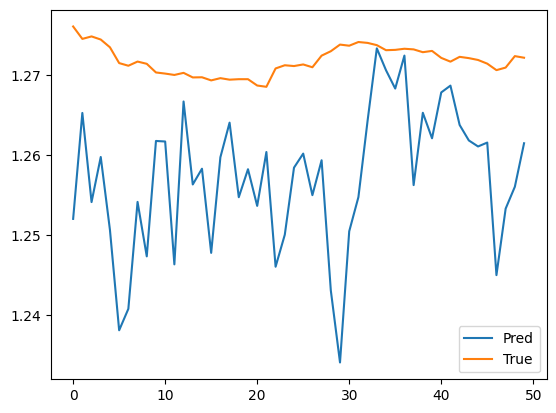

In [56]:
y_pred = model(features)
window_size = 50
start = np.random.randint(0, len(y_pred) - window_size)
print(start)
plt.plot(y_pred.detach().cpu().numpy()[start:start+window_size])
plt.plot(lable.detach().cpu().numpy()[start:start+window_size])
plt.legend(["Pred", "True"])
plt.show()

Feature Analysis

In [30]:
import shap

c:\Users\Carlos\miniconda3\envs\ml\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [31]:
features_lables = df.drop(["Date", "Trading_Price", "Lable"], axis=1).columns.to_numpy()

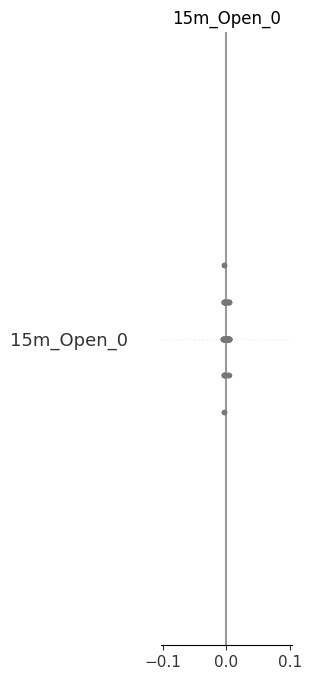

In [33]:
background_size = 1000
test_size = 100
start = np.random.randint(0, len(y_pred) - background_size)

background = X_train[start:start+background_size]
test_samples = X_train[start+background_size:start+background_size+test_size]
explainer = shap.DeepExplainer(
    model, 
    background
)
shap_values = explainer.shap_values(
    test_samples
)

shap.summary_plot(shap_values, features=test_samples, feature_names=features_lables)

In [34]:
shap_df = pd.DataFrame({
    "mean_abs_shap": np.mean(np.abs(shap_values), axis=0).squeeze(), 
    "stdev_abs_shap": np.std(np.abs(shap_values), axis=0).squeeze(), 
    "name": features_lables
})
shap_df.sort_values("mean_abs_shap", ascending=False)

,mean_abs_shap,stdev_abs_shap,name
20,0.018485,0.015938,1H_Volume_0
4,0.009741,0.012130,15m_Volume_0
6,0.003041,0.001281,15m_EMA_20_0
5,0.003024,0.001277,15m_SMA_20_0
12,0.002984,0.001264,15m_Lower_Band_0
17,0.002976,0.001253,1H_High_0
1,0.002965,0.001251,15m_High_0
18,0.002963,0.001253,1H_Low_0
21,0.002954,0.001238,1H_SMA_20_0
10,0.002950,0.001247,15m_Middle_Band_0
